In [162]:
import numpy as np
import pandas as pd
from pandas import TimeGrouper


import seaborn as sns
from sodapy import Socrata

import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot
import matplotlib.patches as mpatches


from functools import reduce
from datetime import timezone, datetime,date
import pytz


pac = pytz.timezone('America/Los_Angeles')
utc = pytz.timezone('UTC')
%matplotlib inline

In [163]:
def Kel_To_Far(k):
    f = 1.8*(k - 273) + 32
    return f


Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('Winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('Spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('Summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('Autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('Winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

In [164]:
#load bike data from Seatlle data API
socrata_domain = 'data.seattle.gov'
socrata_dataset_identifier = '65db-xm6k'
socrata_token  = 'uTBE5rW06JBkufq8UsBellVPy'

client = Socrata(socrata_domain, socrata_token)

results = client.get(socrata_dataset_identifier 
                     ,where= "Date >= '2010-11-01T03:00:00.000' "
                     ,limit = 100000
                    )
fremont = pd.DataFrame.from_records(results)

In [165]:
#Convert date column and set as index
fremont['date'] = pd.to_datetime(fremont.date)
fremont.set_index('date',inplace = True)
fremont.index.names =['Date_Join']

#Convert to numeric columns
fremont['fremont_bridge_nb'] = pd.to_numeric(fremont['fremont_bridge_nb'])
fremont['fremont_bridge_sb'] = pd.to_numeric(fremont['fremont_bridge_sb'])


#Set timezone and sort index
fremont = fremont.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
fremont.sort_index(inplace = True)

#rename
fremont.rename(columns = {'fremont_bridge_nb' : 'EastSide',
                         'fremont_bridge_sb':'WestSide'
                         } , inplace= True)

#FillNA values with mean
fremont['WestSide'].fillna(value = fremont['WestSide'].mean(),inplace = True)
fremont['EastSide'].fillna(value = fremont['EastSide'].mean(),inplace = True)


#calculated Columns
fremont['Mean_Xing'] = fremont[['WestSide','EastSide']].mean(axis=1)
fremont['Total_Xing'] = fremont[['EastSide','WestSide']].sum(axis=1)

fremont['Time_of_Day'] = fremont.index.strftime('%H')
fremont['Month'] = fremont.index.strftime('%m')




print('You have Bridge data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(fremont.shape[0],fremont.shape[1]))
print(fremont.dtypes)


You have Bridge data from 10/03/2012-12AM to 05/31/2019-11PM
There are 58368 observations and 6 columns
EastSide       float64
WestSide       float64
Mean_Xing      float64
Total_Xing     float64
Time_of_Day     object
Month           object
dtype: object


In [166]:
fremont_d = fremont.resample('D').sum()
fremont_d['Month'] = fremont_d.index.strftime('%m')

monthly = fremont.resample('M').sum().rolling(window=3,center=False).mean()
monthly['Month'] = monthly.index.strftime('%m')

weekly = fremont.resample('D').sum().rolling(window=28,center=False).mean()
#monthly['Month'] = monthly.index.strftime('%m')

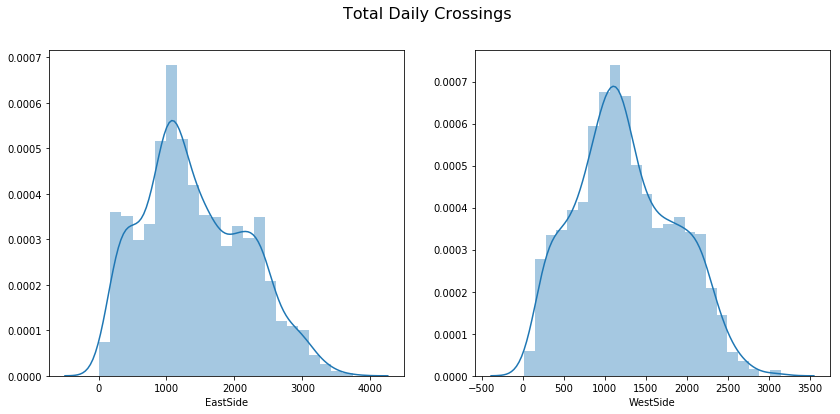

In [167]:
#histogram of bridge crossings
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize = [14,6],)


    sns.distplot(fremont_d['EastSide'],ax=ax1,)
    sns.distplot(fremont_d['WestSide'],ax=ax2,)
    
    
    fig.suptitle('Total Daily Crossings', fontsize=16,color='black')
    ax1.set_xlabel("EastSide", color="black")
    ax2.set_xlabel("WestSide", color="black")
    plt.savefig('./Figures/Daily_Crossing_Hist.png')
    ;

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)


''

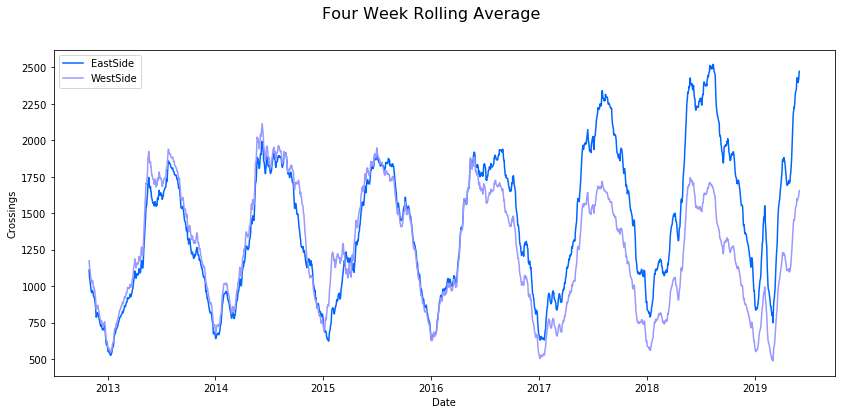

In [168]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = [14,6],)

sns.lineplot(x=weekly.index, y = 'EastSide',color='#0066ff', data = weekly,ax=ax  )
sns.lineplot(x=weekly.index, y = 'WestSide',color='#9999ff', data = weekly,ax=ax   )
fig.suptitle('Four Week Rolling Average', fontsize=16,color='black')
ax.set_ylabel("Crossings", color="black")
ax.set_xlabel("Date", color="black")
ax.legend(['EastSide','WestSide'],loc="upper left")

plt.savefig('./Figures/Four_Week_Average.png')
#0066ff
;


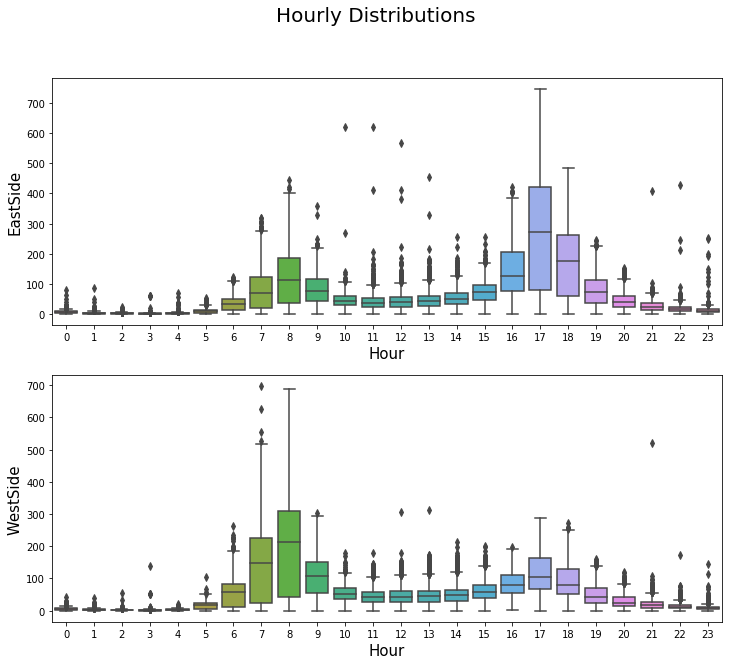

In [169]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, (ax1,ax2) = plt.subplots(nrows= 2, ncols =1 ,figsize=(12,10))
    sns.boxplot(x=fremont.index.hour,y=fremont['EastSide'],data= fremont, ax=ax1)
    sns.boxplot(x=fremont.index.hour,y=fremont['WestSide'],data= fremont, ax=ax2)
    
    fig.suptitle('Hourly Distributions', fontsize=20,color='black')
    ax1.set_xlabel("Hour", color="black",size=15)
    ax2.set_xlabel("Hour", color="black",size=15)
    ax1.set_ylabel("EastSide", color="black",size=15)
    ax2.set_ylabel("WestSide", color="black",size=15)
    plt.savefig('./Figures/Hourly_Box_Plot.png')

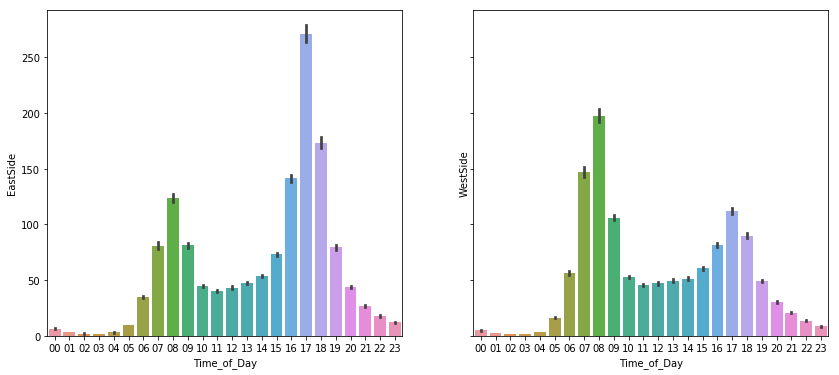

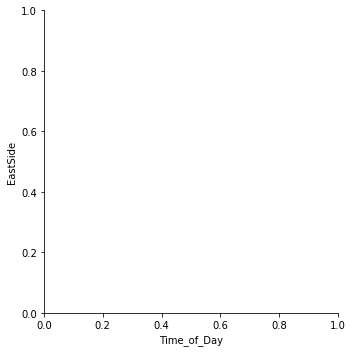

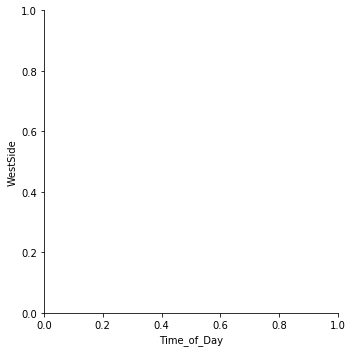

In [170]:
fig, (ax1, ax2) = plt.subplots(nrows =1 ,ncols=2,figsize = [14,6], sharey=True)
sns.catplot(x="Time_of_Day",y="EastSide",data=fremont,kind='bar',ax=ax1)
sns.catplot(x="Time_of_Day",y="WestSide",data=fremont,kind='bar',ax=ax2)

In [171]:
path = "./Data/Daily_Summaries/Daily_Summaries_Merged.csv"
d = ","
wx = pd.read_csv(path,delimiter=d)
wx.DATE = pd.to_datetime(wx.DATE)
wx.rename(columns={'DATE':'Date_Join'},inplace = True)
wx.drop(['LATITUDE','LONGITUDE'],axis = 1,inplace=True)
;

''

In [172]:
wx.loc[wx['STATION'] == 'USW00024233', 'NAME'] = 'SeaTac'
wx.loc[wx['STATION'] == 'USW00024234', 'NAME'] = 'Boeing_Field'
wx.loc[wx['STATION'] == 'US1WAKG0079', 'NAME'] = 'Magnolia'
wx.loc[wx['STATION'] == 'US1WAKG0145', 'NAME'] = 'Phinney'
wx.loc[wx['STATION'] == 'US1WAKG0200', 'NAME'] = 'Georgetown'
wx.loc[wx['STATION'] == 'US1WAKG0199', 'NAME'] = 'GreenWood'
wx.loc[wx['STATION'] == 'US1WAKG0225', 'NAME'] = 'Cap_Hill'
wx.loc[wx['STATION'] == 'US1WAKG0239', 'NAME'] = 'Woodland_Park'

In [173]:
#average WX observations together to get daily totals
wx_d = wx.groupby(by = 'Date_Join')[['PRCP','TMAX','TMIN']].mean()
wx_d = wx_d.tz_localize(pac,ambiguous = True, nonexistent = 'shift_forward')
wx_d['Rain_Day'] = (wx_d['PRCP'] > .1)
print('You have WX data from {} to {}'.format(wx_d.index.min().strftime('%m/%d/%Y-%I%p'),wx_d.index.max().strftime('%m/%d/%Y-%I%p')))

You have WX data from 01/01/2010-12AM to 05/15/2019-12AM


In [174]:
#wx.head()
#wx_d.head()

In [175]:
grouped = wx_d.groupby([wx_d.index.month],as_index=True)
result = grouped.agg({"PRCP" :"sum",'TMAX':'mean','Rain_Day':['sum','count']})


df = pd.DataFrame()
df['Total_Days'] =result.Rain_Day['count']
df['Rain_Days'] =result.Rain_Day['sum']
df['TMAX'] = result.TMAX
df['Clear_Days'] =result.Rain_Day['count'] - result.Rain_Day['sum']

In [176]:
df.sum()

Total_Days    3422.00000
Rain_Days     1005.00000
TMAX           737.73267
Clear_Days    2417.00000
dtype: float64

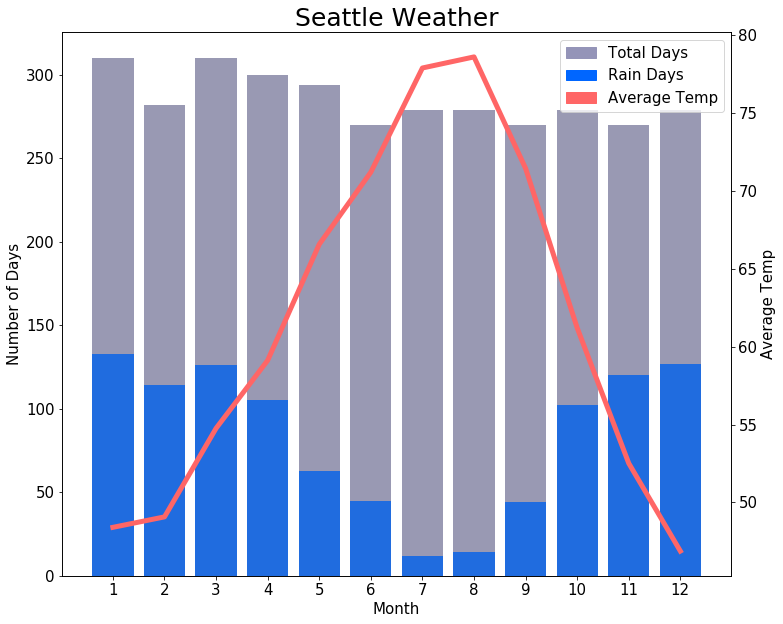

In [177]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black','font.size' : '15'}):
    fig, ax = plt.subplots(1,1, figsize=(12,10))
    sns.barplot(x=df.index, y="Total_Days",data=df,color='#9494b8')
    sns.barplot(x=df.index, y="Rain_Days",data=df,color='#0066ff')

    ax2 = ax.twinx()

    sns.lineplot(x=df.index-1 , y="TMAX",data=df,color='#ff6666', ax=ax2, LW = 5)

    ax.set_xlabel("Month", color="black",size=15)
    ax2.set_ylabel("Average Temp", color="black",size=15)
    ax.set_ylabel('Number of Days', color="black",size=15)
    ax.set_title('Seattle Weather',color='black',size=25)
    total = mpatches.Patch(color='#9494b8', label='Total Days')
    rain = mpatches.Patch(color='#0066ff', label='Rain Days')
    temp = mpatches.Patch(color='#ff6666', label='Average Temp')
    plt.legend(handles=[total,rain,temp])
    plt.savefig('./Figures/SEA_WX.png')

In [178]:
#Merge WX and Fremont
data = fremont_d.merge(wx_d, how = 'inner',left_on = 'Date_Join',right_on = 'Date_Join')
print('You have combined data from {} to {}'.format(fremont.index.min().strftime('%m/%d/%Y-%I%p'),fremont.index.max().strftime('%m/%d/%Y-%I%p')))

#data.head()

You have combined data from 10/03/2012-12AM to 05/31/2019-11PM


C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:915: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1260: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64

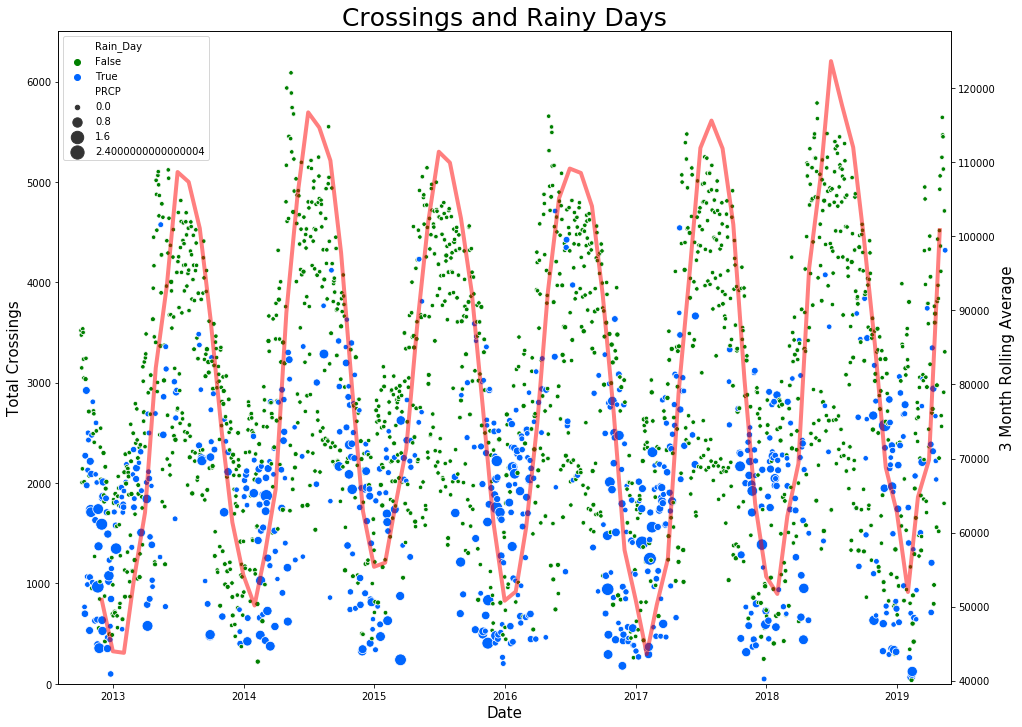

In [179]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, ax = pyplot.subplots(figsize=(16,12))

    sns.scatterplot(x=data.index, 
                    y="Total_Xing", 
                    data=data,
                    size='PRCP',
                    sizes=(20, 175),
                    hue='Rain_Day',
                    legend='brief',    
                    palette=['#008000','#0066ff'],
                    ax = ax
                         )

    ax.set_xlim('8/1/2012', '6/1/2019')
    ax.set_ylim(0, 6500)
    ax.set_xlabel("Date", color="black",size=15)
    ax.set_ylabel('Total Crossings', color="black",size=15)
    ax.set_title('Crossings and Rainy Days',color='black',size=25)
    ax.legend(loc='upper left')
   
    
    ax2 = ax.twinx()
    sns.lineplot(x=monthly.index-1, y = 'Total_Xing', data = monthly,ax=ax2,color='#ff0000',alpha=.5,lw = 4)
    ax2.set_ylabel('3 Month Rolling Average', color="black",size=15)
    plt.savefig('./Figures/Crossing_Rain_Scatter_total.png')
    ;

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:915: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1260: FutureWarning: Addition/subtraction of integers and integer-arrays to DatetimeArray is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  maybe_integer_op_deprecated(self)
C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\seaborn\relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64

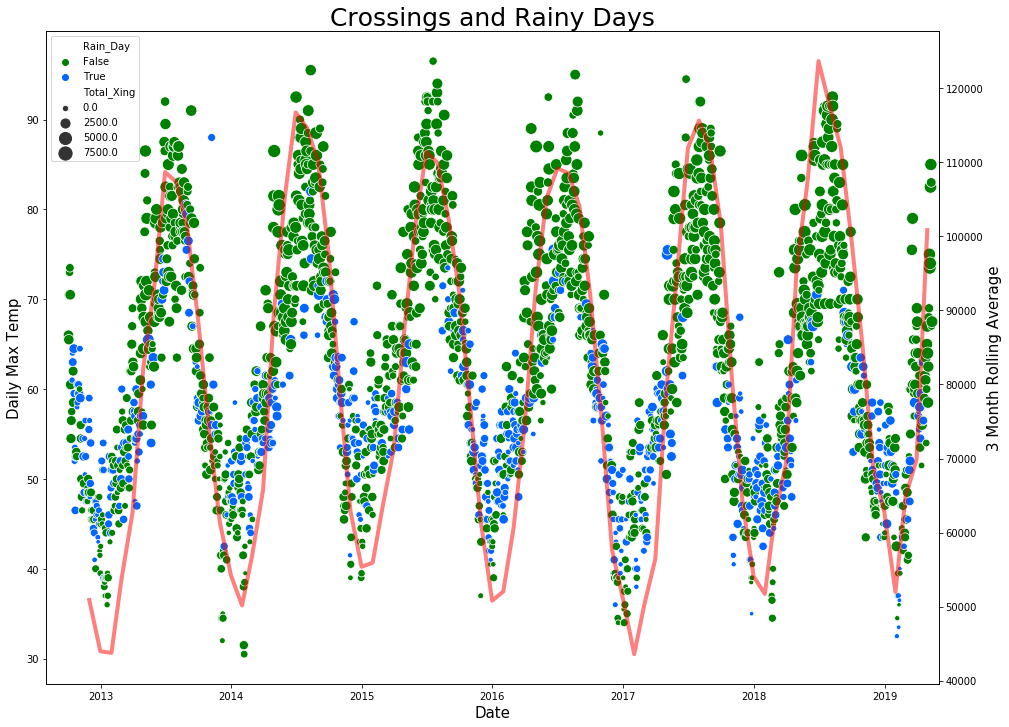

In [180]:
with plt.rc_context({'xtick.color':'black', 'ytick.color':'black'}):
    fig, ax = pyplot.subplots(figsize=(16,12))

    sns.scatterplot(x=data.index, 
                    y="TMAX", 
                    data=data,
                    size='Total_Xing',
                    sizes=(20, 175),
                    hue='Rain_Day',
                    legend='brief',    
                    palette=['#008000','#0066ff'],
                    ax = ax
                         )

    ax.set_xlim('8/1/2012', '6/1/2019')
    #ax.set_ylim(0, 100)
    ax.set_xlabel("Date", color="black",size=15)
    ax.set_ylabel('Daily Max Temp', color="black",size=15)
    ax.set_title('Crossings and Rainy Days',color='black',size=25)
    ax.legend(loc='upper left')
    
   
    
    ax2 = ax.twinx()
    sns.lineplot(x=monthly.index-1, y = 'Total_Xing', data = monthly,ax=ax2,color='#ff0000',alpha=.5,lw = 4)
    ax2.set_ylabel('3 Month Rolling Average', color="black",size=15)
    plt.savefig('./Figures/Crossing_Rain_Scatter_Temp.png')
    ;

In [182]:
#load Weather Data
path = './Data/OpenWeatherMap/OpenWeatherMap_Seattle_Bulk.csv'
wx_hourly = pd.read_csv(path)

#format date column and set as index. Convert to Pacifict time. Original data in UTC
wx_hourly['dt_iso']=pd.to_datetime(wx_hourly['dt_iso'], format = '%Y-%m-%d %H:%M:%S +%f %Z' )
wx_hourly = wx_hourly.set_index('dt_iso')
wx_hourly = wx_hourly.tz_convert(pac)
wx_hourly.index.names =['Date_Join']


#convert temps from Kelving to Farenheit
wx_hourly['temp_f'] = wx_hourly.temp.apply(Kel_To_Far)
wx_hourly['temp_min_f'] = wx_hourly.temp_min.apply(Kel_To_Far)
wx_hourly['temp_max_f'] = wx_hourly.temp_max.apply(Kel_To_Far)



#drop unused column and re-order logically
wx_hourly.drop(['lat','lon','city_id','city_name','temp','temp_min','temp_max','sea_level','grnd_level','dt','weather_icon'],axis = 1,inplace=True)
wx_hourly.drop(['rain_3h','snow_3h','rain_24h','snow_24h','rain_today','snow_today'],axis = 1,inplace=True)
wx_hourly.drop(['weather_main','weather_id'],axis = 1,inplace=True)
 
neworder =['temp_f','temp_min_f','temp_max_f','pressure', 'humidity', 'wind_speed', 'wind_deg',
            'rain_1h','snow_1h', #'rain_3h','snow_3h','rain_24h','snow_24h', 'rain_today','snow_today',
            'clouds_all','weather_description'#, 'weather_main','weather_id'
          ]
wx_hourly=wx_hourly.reindex(columns=neworder)


#fill NA data with 0
wx_hourly['rain_1h'].fillna(value = 0,inplace = True)
wx_hourly['snow_1h'].fillna(value = 0,inplace =True)

#Calculated Columns
wx_hourly['Time_of_Day'] = wx_hourly.index.strftime('%H')
wx_hourly['Month'] = wx_hourly.index.strftime('%m')
wx_hourly['WeekDay'] = wx_hourly.index.strftime('%A')
wx_hourly['Season'] = wx_hourly.index.to_series().apply(get_season)

#Dummy Columns
#wx_hourly = pd.get_dummies(data=wx_hourly,columns = ['weather_description','Season','Time_of_Day','Month','WeekDay'])


#wx_hourly.head(5)
print('You have Weather data from {} to {}'.format(wx_hourly.index.min().strftime('%m/%d/%Y-%I%p'),wx_hourly.index.max().strftime('%m/%d/%Y-%I%p')))
print('There are {} observations and {} columns'.format(wx_hourly.shape[0],wx_hourly.shape[1]))
#print(wx_hourly.dtypes)

C:\Users\cody.ringrissler\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: The default of the 'keep_tz' keyword will change to True in a future release. You can set 'keep_tz=True' to obtain the future behaviour and silence this warning.


You have Weather data from 10/01/2012-06AM to 06/13/2019-05PM
There are 56675 observations and 15 columns


In [210]:
description_plot = pd.DataFrame(wx_hourly['weather_description'].value_counts())
description_plot.reset_index(inplace=True)
sns.heatmap(description_plot)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

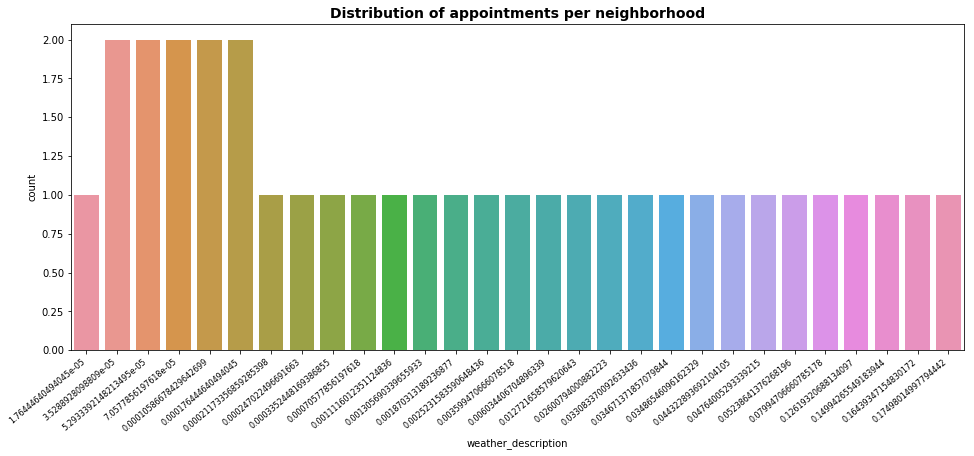

In [206]:
#wx_hourly['weather_description']


## Plotting an histogram with the neighborhoods sorted alphabetically. 
plt.figure(figsize=(16,6))
ax = sns.countplot(x='weather_description', data=description_plot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=8)
plt.title('Distribution of appointments per neighborhood', fontsize=14, fontweight='bold')
plt.show()

In [188]:
sns.heatmap(wx_hourly)
#wx_hourly.weather_description.value_counts()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [17]:
#wx_d.sort_values(by='PRCP',ascending=False).head()

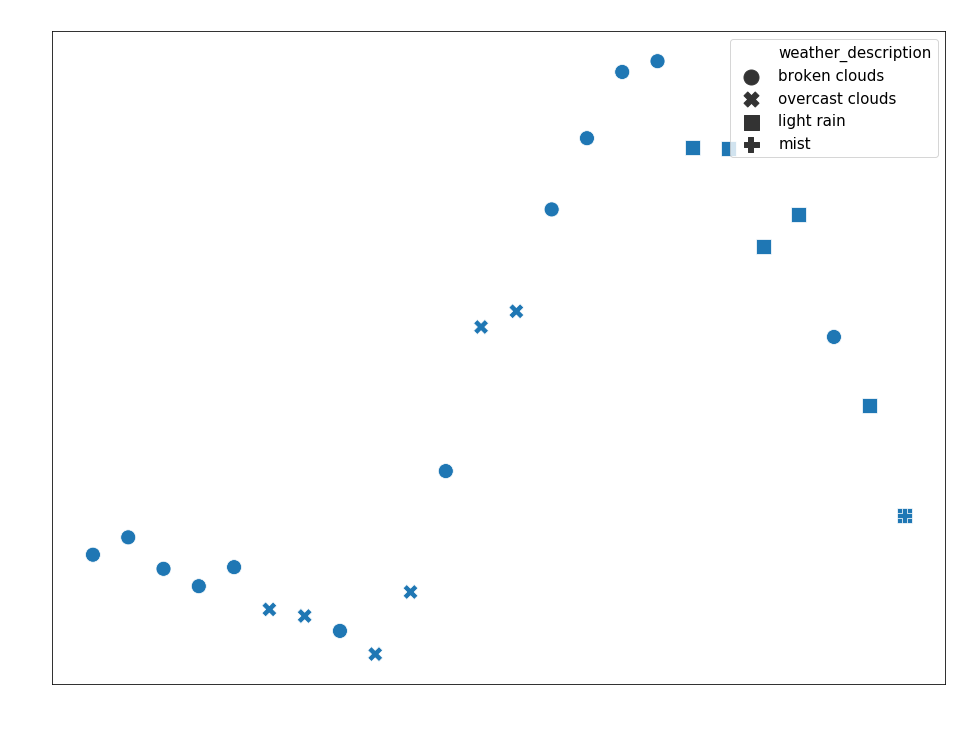

In [18]:
#day_plot = wx_hourly.loc['2017-01-18', ['temp_f','humidity','rain_1h','weather_description']]
day_plot = wx_hourly.loc['2018-09-21', ['temp_f','humidity','rain_1h','weather_description']]

with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','font.size' : '15','lines.markersize': '15.0'}):
    fig, ax = pyplot.subplots(figsize=(16,12))

    sns.scatterplot(x=day_plot.index.hour, 
                    y="temp_f", 
                    data=day_plot,
                    style = 'weather_description',
                    #size='rain_1h',
                    #sizes=(20, 100),
                    #hue='Rain_Day',
                    legend='full',    
                    #palette=['gray','dodgerblue'],
                    ax = ax
                         )
    ax.set_xlabel("Hour", color="white",size=15)
    ax.set_ylabel('Temp', color="white",size=15)
    ax.set_title('Hourly WX 1/17/2018',color='white',size=25)